(0.001, 0.2)

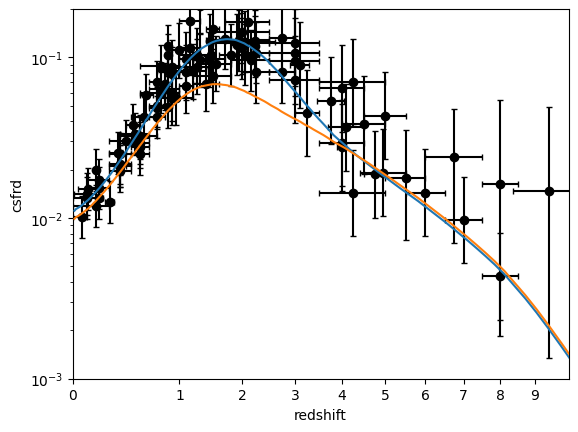

In [1]:
#Behroozi 2019 plot

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

import lbg_forecast.cosmology as cos

data = ascii.read("csfr_data/csfrs.dat")  

scale = np.array(data["Scale"])
redshift = cos.scale_to_z(scale)
total_obs_csfr = np.array(data["Total_Obs_CSFR"])
total_obs_csfr_err_p = np.array(data["Err+"])
total_obs_csfr_err_n = np.array(data["Err-"])

total_obs_csfr_uv = np.array(data["Total_Obs_CSFR_UV"])
total_obs_csfr_uv_err_p = np.array(data["Err+_1"])
total_obs_csfr_uv_err_n = np.array(data["Err-_1"])

true_csfr = np.array(data["True_CSFR"])
true_csfr_err_p = np.array(data["Err+_2"])
true_csfr_err_n = np.array(data["Err-_2"])

plt.errorbar(redshift, total_obs_csfr, zorder=1000)#, yerr=[total_obs_csfr_err_n, total_obs_csfr_err_p])
#plt.errorbar(redshift, total_obs_csfr_uv, zorder=1000)#, yerr=[total_obs_csfr_uv_err_n, total_obs_csfr_uv_err_p])
plt.errorbar(redshift, true_csfr, zorder=1000)#, yerr=[true_csfr_err_n, true_csfr_err_p])


# Function x**(1/2)
def forward(x):
    return abs(x)**(1/1.5)

def inverse(x):
    return x**(1.5)


data = ascii.read("csfr_data/obs.txt")
csfr_rows = data['Type']=="csfr"
csfr_uv_rows = data['Type']=="csfr_(uv)"
rows = np.logical_or(csfr_rows, csfr_uv_rows)

z1 = np.array(data["Z1"])[rows]
z2 = np.array(data["Z2"])[rows]
redshift = (z2+z1)/2

z_err_l = redshift-z1
z_err_h = z2-redshift

log_val = np.array(data["Val"])[rows]
log_err_h = np.array(data["Err_h"])[rows]
log_err_l = np.array(data["Err_l"])[rows]

log_val_err_h = log_val + log_err_h
log_val_err_l = log_val - log_err_l

val = 10**log_val
val_err_h = 10**log_val_err_h
val_err_l = 10**log_val_err_l

err_h = val_err_h - val
err_l = val - val_err_l

plt.errorbar(redshift, val, yerr=[err_l, err_h], xerr=[z_err_l, z_err_h], fmt='ko', capsize=2)
plt.yscale("log")
plt.xscale('function', functions=(forward, inverse))
plt.xlabel("redshift")
plt.ylabel("csfrd")
plt.xticks(np.arange(0, 10, 1.0))
plt.xlim(0, 10)
plt.ylim(0.001, 0.2)